In [1]:
import os
os.chdir('/rd2/user/xiacr/sle/other_sc_data/')

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

import glob
import anndata as ad
import collections

import scanpy.external as sce

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=160, facecolor='white', fontsize=10)
sc._settings.ScanpyConfig.n_jobs = 36

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.8 pynndescent==0.5.5


In [4]:
file_list = glob.glob('h5ad/*.h5ad')
file_list

['h5ad/EBioMedicine_21.h5ad',
 'h5ad/nc_19_sle_flare.h5ad',
 'h5ad/nbt_17.h5ad',
 'h5ad/nc_19_sle.h5ad',
 'h5ad/natimm_20.h5ad',
 'h5ad/pnas_19.h5ad']

In [5]:
adatas = []
for file in file_list:
    # print(file.split('/')[1].split('_')[0])
    tmp_adata = sc.read_h5ad(file)
    tmp_adata.var_names_make_unique()
    tmp_adata.obs['batch'] = file.split('/')[1].split('_')[0]
    adatas.append(tmp_adata)

In [6]:
adata = adatas[0].concatenate(adatas[1:])


KeyError: 'sample'

In [7]:
adata.obs['batch'].value_counts()
adata
del adatas

## QC(not do real qc)

filtered out 13469 cells that have less than 300 genes expressed


/home/xiacr/miniconda3/envs/sle/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/xiacr/miniconda3/envs/sle/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'barcode' as categorical


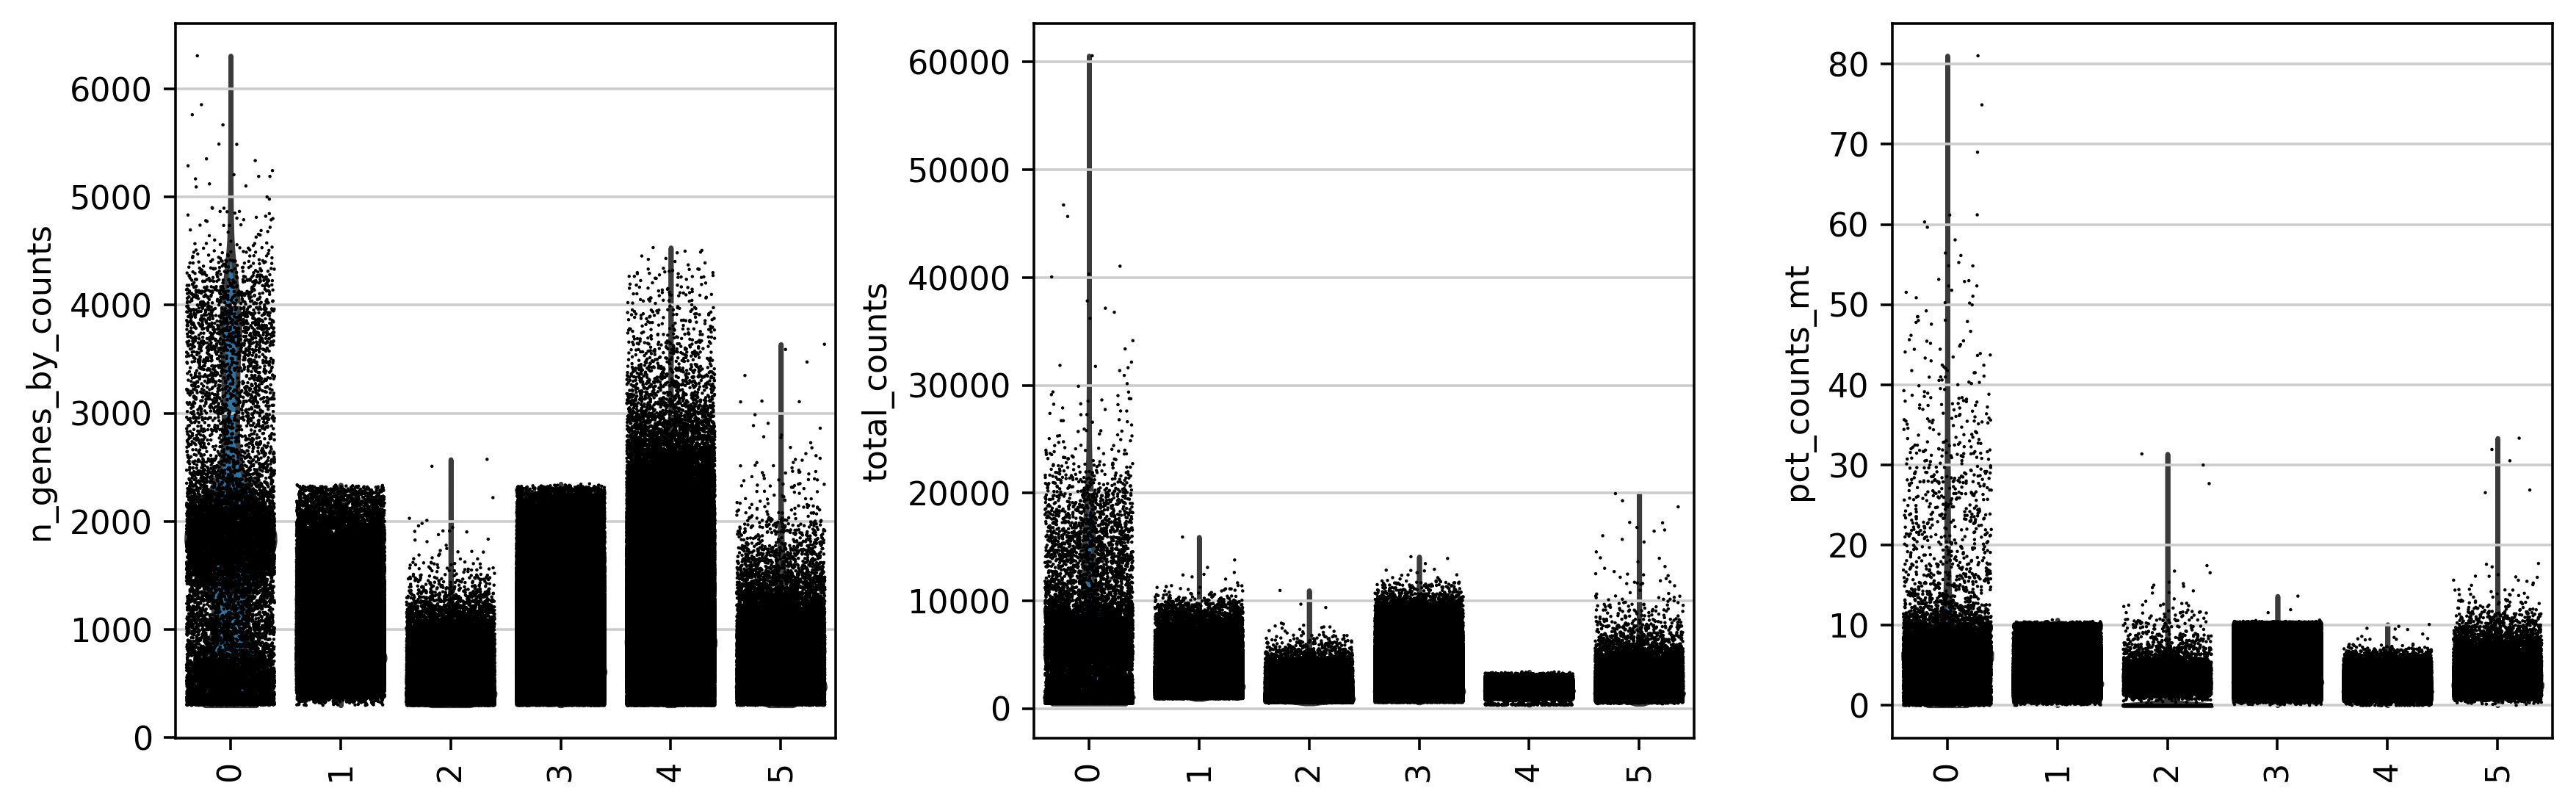

In [9]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],groupby='batch', rotation= 90,
             jitter=0.4, multi_panel=True,)

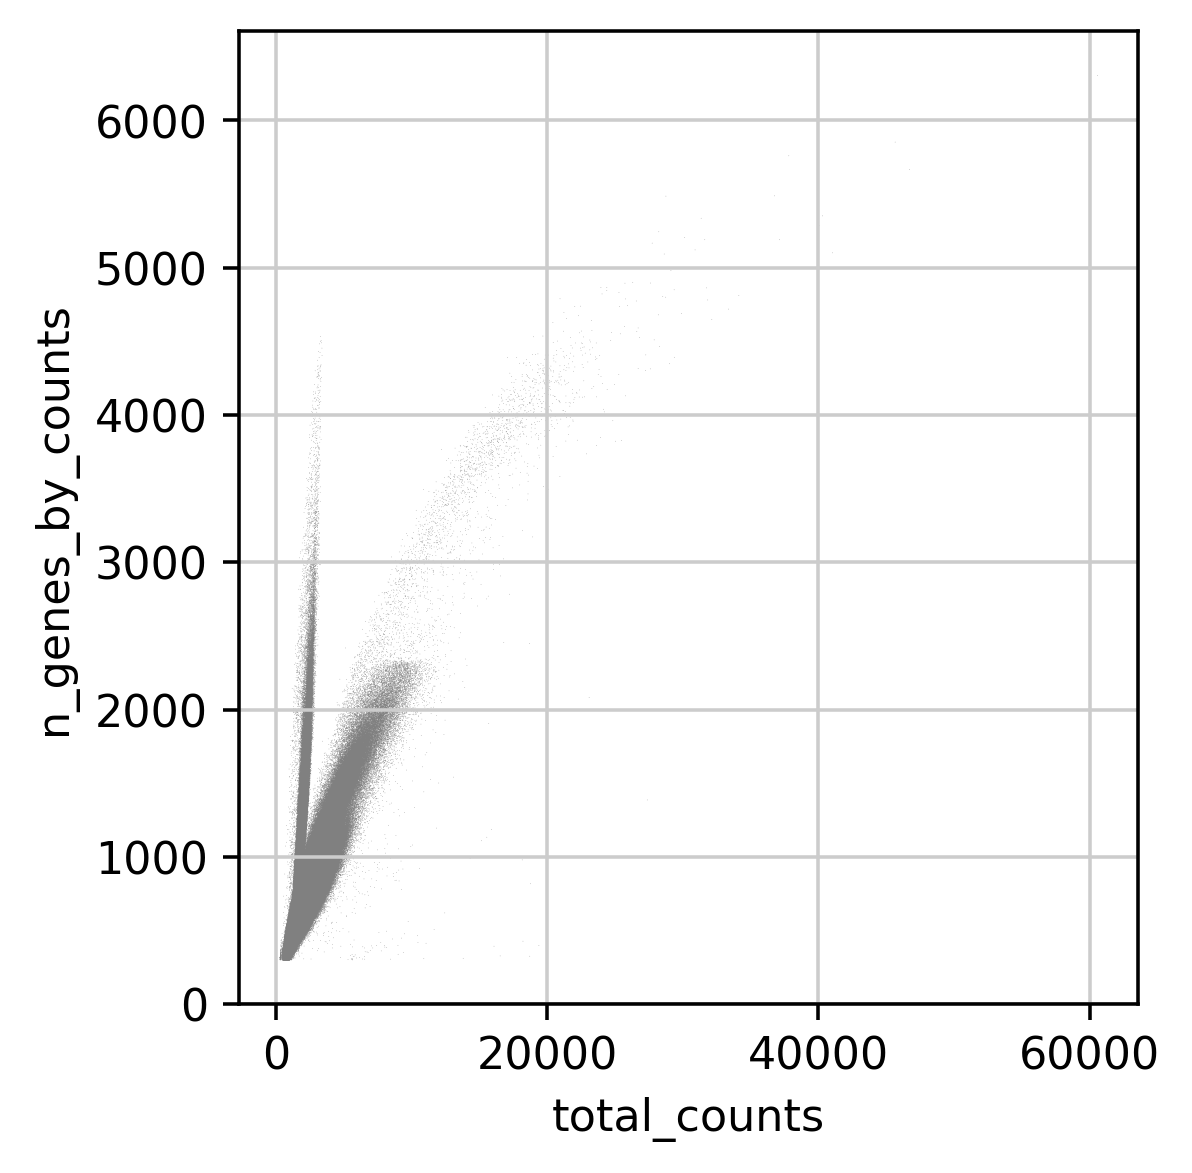

In [10]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## single cell pipeline

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/xiacr/miniconda3/envs/sle/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


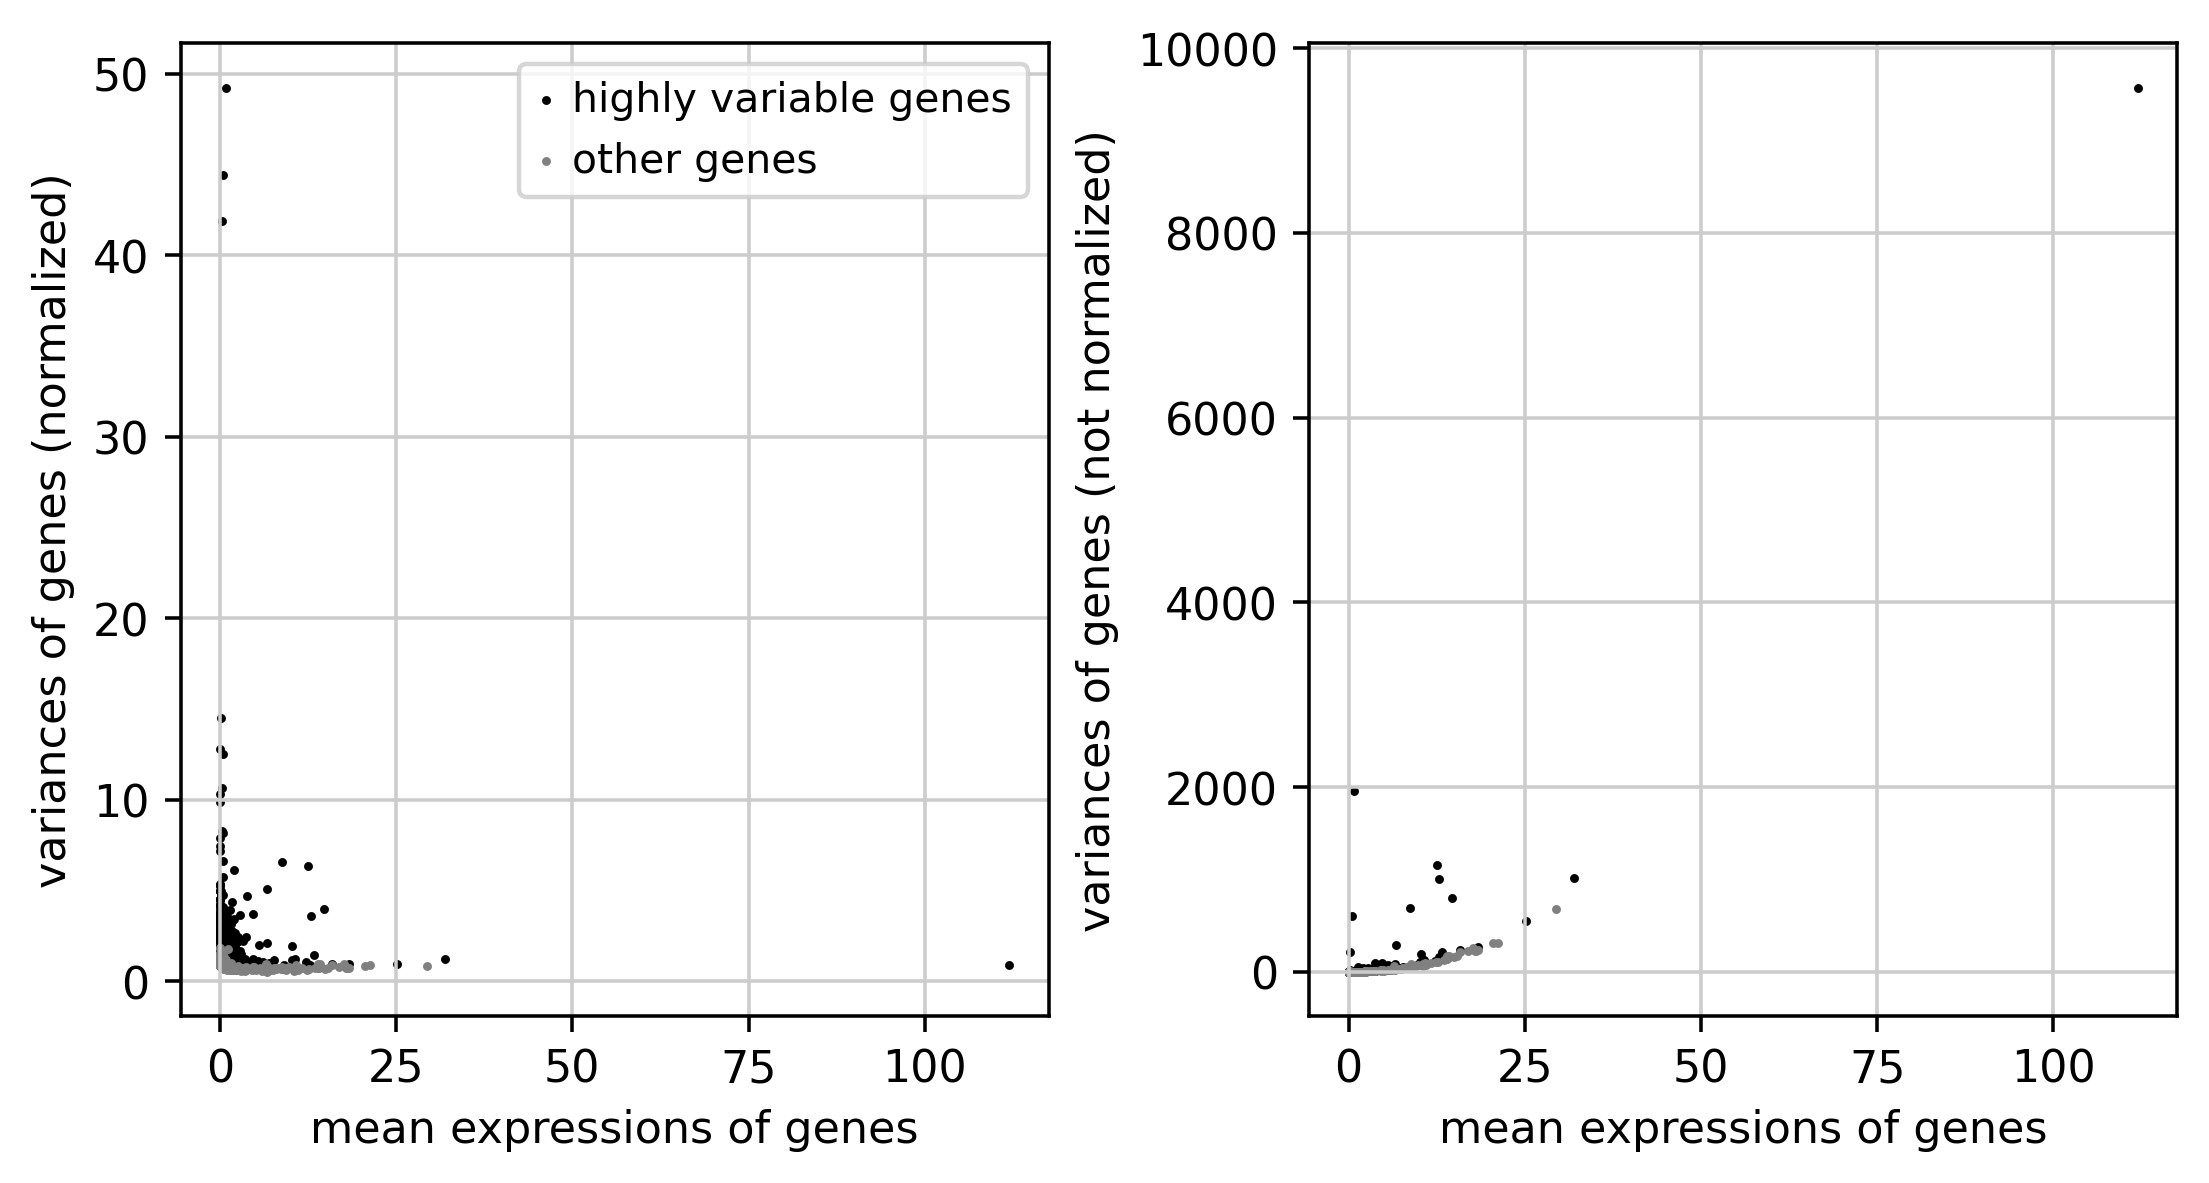

normalizing counts per cell
    finished (0:00:10)


In [11]:
sc.pp.highly_variable_genes(adata, flavor ='seurat_v3',n_top_genes =2500, batch_key ='batch') # must specify n_top_genes when using seurat v3
sc.pl.highly_variable_genes(adata)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [12]:
adata.raw = adata # You can get back an AnnData of the object in .raw by calling .raw.to_adata().
adata = adata[:, adata.var.highly_variable]

In [13]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # long time

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:08:10)


In [14]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:02:42)


## BBKNN

In [18]:
%%time
sc.external.pp.bbknn(adata, batch_key='batch')  # running bbknn 1.3.6

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:05:25)
CPU times: user 5min 41s, sys: 14.5 s, total: 5min 56s
Wall time: 5min 25s


In [19]:
adata

AnnData object with n_obs × n_vars = 1424899 × 2500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'Run', 'BioSample', 'biospecimen_repository_sample_id', 'Bytes', 'Center.Name', 'Consent_Code', 'Consent', 'DATASTORE.filetype', 'DATASTORE.provider', 'DATASTORE.region', 'Experiment', 'Library.Name', 'Sample.Name', 'sex', 'submitted_subject_id', 'subject_is_affected', 'AvgSpotLen', 'Bases', 'study_disease', 'barcode', 'group', 'percent_mito', 'percent_ribo', 'RNA_snn_res.0.8', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'name-0', 'name-1', 'name-2', 'name-3', 'vst.mean-4', 'vst.variance-4', 'vst.variance.expected-4', 'vst.variance.standardized-4', 'vst.variable-4', 'name-5', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 

In [ ]:
sc.tl.leiden(adata)
sc.tl.umap(adata)

running Leiden clustering


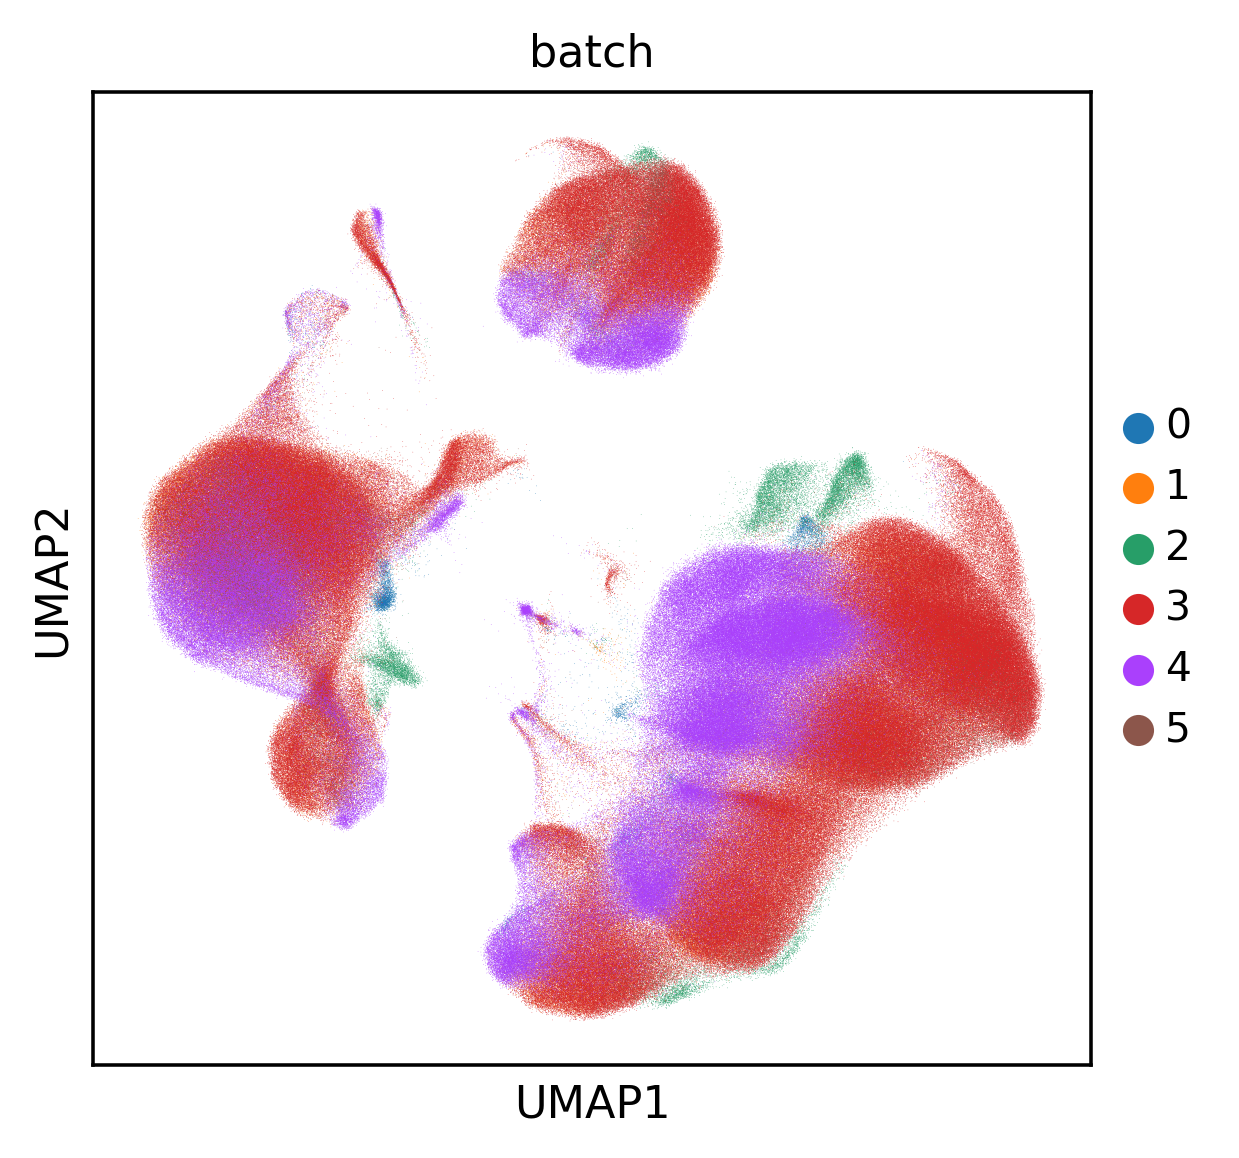

In [24]:
sc.pl.umap(adata,color=['batch'])